## Library introduction 
This notebook is a walkthorugh the basic concepts in the PyMTJ library and covers the basics of using the C++ bindings in Python.

### Voltage Spin Diode & IEC
In the first section, we will run the basic voltage spin diode experiment using the IEC (Interlayer Exchange Coupling) excitation.  

### STT
In the second section, we are going to construct the Spin Torque Oscillator (STO) using the STT (Slonczewski Spin Torque) addition to our LLG equations. STO is able to sustain the magnetisation precession for a prolonged period of time, since the spin-polarised current flowing through the junction compensates the energy losses from the Gilbert's damping contribution.

In [1]:
from cmtj import Junction, Layer, CVector, Axis, ScalarDriver, AxialDriver, NullDriver
import numpy as np 
import time 

We start with the definition of our Junction, which in turn is composed from two layers.
Here are some key parameters:
- mag - magnetisation vector
- anis - the vector (axis) of the magnetic anisotoropy 
- K - magnetic anisotropy $[J/m^3]$
- Ms - magnetisation saturation $[A/m]$
- thickness - thickness of the layer $[m]$
- J - the IEC coupling with the other layers $[J/m^2]$

In [2]:
dipoleTensor = [
    CVector(6.8353909454237e-4, 0., 0.),
    CVector(0., 0.00150694452305927, 0.),
    CVector(0., 0., 0.99780951638608)
]
demagTensor = [
    CVector(5.57049776248663e-4, 0., 0.),
    CVector(0., 0.00125355500286346, 0.),

    CVector(0., 0.0, -0.00181060482770131)
]

l1 = Layer(id="free", 
           mag=CVector(0., 0., 1.), 
           anis=CVector(0, 0., 1.), 
           Ms=1200e3,
           thickness=1.4e-9, 
           cellSurface=7e-10 * 7e-10, 
           demagTensor=demagTensor, 
           dipoleTensor=dipoleTensor)
l2 = Layer(id="bottom", 
           mag=CVector(0., 0., 1.), 
           anis=CVector(0, 0., 1.), 
           Ms=1000e3, 
           thickness=7e-9, 
           cellSurface=7e-10 * 7e-10, 
           demagTensor=demagTensor, 
           dipoleTensor=dipoleTensor)

junction = Junction([l1, l2], "csv.csv", 100, 200)

junction.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(900e3))
junction.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1500e3))

## Voltage Spin Diode effect
As we have defined the Junction, we now proceed to running the Voltage Spin Diode experiment. 

To perform the VSD the external magnetic field is swept in some range, in this case we picked 30 points in range from 0 to 600 mT. For each field point we solve the LLG under the specific excitation and frequency. 

In this example we will be exciting the system with its resonant frequency which is given _a priori_ but you may find it with the FFT analysis included in the PyMTJ package as well. We skipped that part for clarity.
For each of the points we will calculate the constant voltage (Vmix, the diode voltage) arising from the interaction between the sinusoidal current flowing throught the MTJ (of 0 phase and frequency equal to that of the resonant frequency) and also oscillating magnetoresistance, which in turn is invoked by the oscillating magnetisation in response to the effective field contributions.

Other parameters were fixed so that we get a nice result, but feel free to tinker with the options and see what happens. 

In [3]:
from collections import defaultdict

data = defaultdict(list)
start = time.time()
TtoAm = 795774.715459 #
freq = 7e9

# here we set the constant excitation with IEC
# -3e-6 is the constant coupling and 1e6 is the amplitude of the sine excitation
junction.setLayerIECDriver("free", ScalarDriver.getSineDriver(
    -3e-6, 1e-6, freq, 0))
junction.setLayerIECDriver("bottom", ScalarDriver.getSineDriver(
    -3e-5, 1e-6, freq, 0))

for field in np.linspace(0, 0.6, 30):
    # clean the log so that we get unbiased results
    junction.clearLog()
    # here we set the junction excitation to evoke the oscillations of mag.
    junction.setLayerExternalFieldDriver("all", 
                            AxialDriver(                 
                                [ScalarDriver.getConstantDriver(field*TtoAm),
                                NullDriver(), 
                                NullDriver()]))
    # run this simulation
    junction.runSimulation(20e-9, 1e-13, False, False)
    # the calculation of the VSD voltage takes place here 
    res = junction.calculateVoltageSpinDiode(freq, power=10e-6, minTime=10e-9)
    data['Rpp'].append(res['Rpp'])
    data['Vmix'].append(res['Vmix']*1e6)
    data['H'].append(field*1000)
end = time.time()
print(f"Simulation time: {end-start}")

Simulation time: 5.24849009513855


Now, we may plot our Voltage Spin Diode curve, which is a ferromagnetic resonance curve -- the FMR (fitting the antisymmetric Lorentz curve), being a Vmix function of the field applied to the junction. 

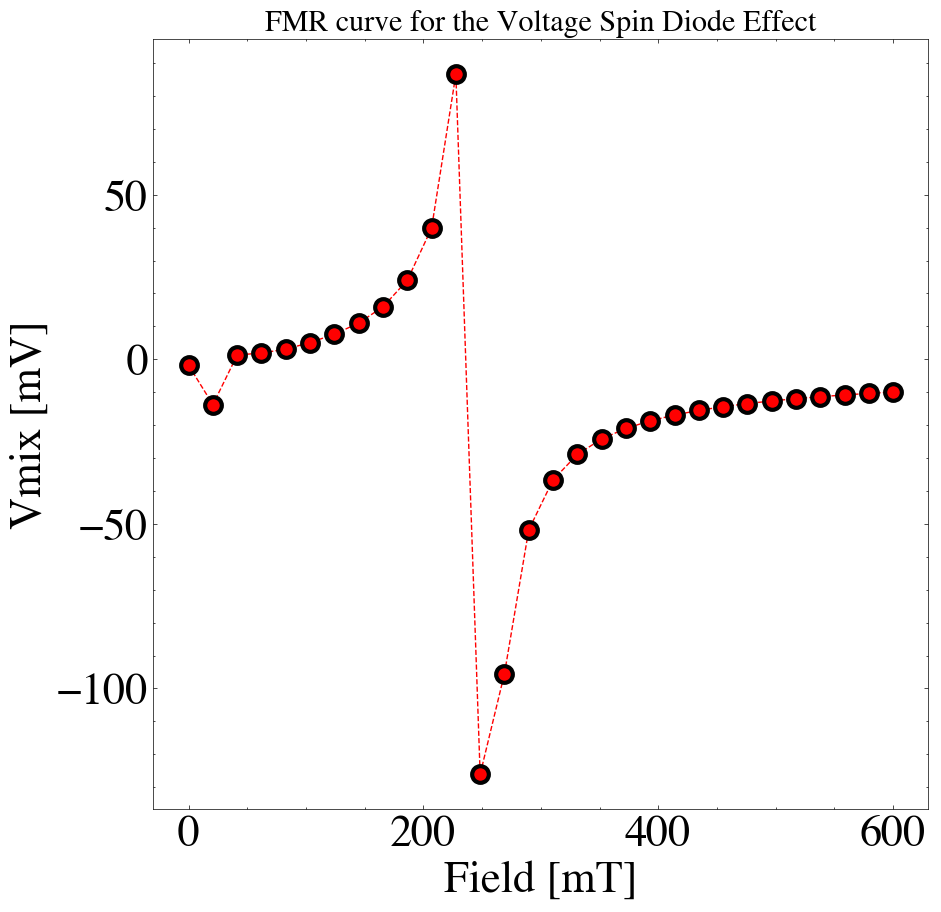

In [10]:
import matplotlib.pyplot as plt 
plt.style.use('default')
fsize= 32
plt.rcParams['figure.figsize'] = [10, 6]
plt.rc('font', family='serif', serif='Times', size=18)
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=fsize)
plt.rc('ytick', labelsize=fsize)
plt.rc('axes', labelsize=fsize)

plt.rc('mathtext',**{'default':'regular'})

with plt.style.context(['science', 'no-latex']):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(data['H'], data['Vmix'],
            'o--',
            color='red',
            markersize=12,
            markeredgecolor='k',
            markeredgewidth=3)
    ax.set_xlabel("Field [mT]")
    ax.set_ylabel("Vmix [mV]")
    ax.set_title("FMR curve for the Voltage Spin Diode Effect")
plt.show()

## STT
We may now transition to simulating Spin Torque Oscillators. As mentioned before, these are called the oscillators because they can sustain the oscillating magnetisation. 

This experiment is much simpler than the previous one. Like before, we will set up our layers, but this time, we will enable the STT contributions and we will invoke the critical current densities.

Note, we turn the STT in the free layer, which has now the magnetisation in the -z direction.
Additionally, we lower the free layer anisotropy and we turn off the coupling (for simplicity).

We also slightly tilt the bottom layer's magnetisation in order to invoke the torque on the spin torque. 

In [5]:
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
def plot_trajectories(df, title):
    with plt.style.context(['science', 'no-latex']):
        fig = plt.figure(figsize=(18, 10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.set_title("Free layer magnetisation trajectory")
        ax.plot3D(df[f'free_mx'],
                df[f'free_my'],
                df[f'free_mz'])
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(df['time'], df['R_free_bottom'])
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("Magnetoresistance [Ohm]")
        # fig.tight_layout()
        fig.suptitle(title)


In [6]:
dipoleTensor = [
    CVector(0., 0., 0.),
    CVector(0., 0., 0.),
    CVector(0., 0., 1.0)
]
demagTensor = [
    CVector(5.57049776248663e-4, 0., 0.),
    CVector(0., 0.00125355500286346, 0.),

    CVector(0., 0.0, -0.00181060482770131)
]

damping = 0.03
currentDensity = 1e10
beta = 1
spinPolarisation = 1.0

l1 = Layer(id="free", 
           mag=CVector(0., 0., -1.), 
           anis=CVector(0, 0., 1.), 
           Ms=1200e3,
           thickness=1.4e-9, 
           cellSurface=7e-10 * 7e-10, 
           demagTensor=demagTensor, 
           dipoleTensor=dipoleTensor,
           includeSTT=True,
           damping=damping,
           SlonczewskiSpacerLayerParameter=1.0,
           spinPolarisation=spinPolarisation,
           beta=beta)
l2 = Layer(id="bottom", 
           mag=CVector(0., 1., 1.), 
           anis=CVector(0, 1., 1.), 
           Ms=1000e3, 
           thickness=3e-9, 
           cellSurface=7e-10 * 7e-10, 
           demagTensor=demagTensor, 
           dipoleTensor=dipoleTensor)

junction = Junction([l1, l2], "STT.csv", 100, 200)

junction.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(800e3))
junction.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1500e3))
junction.setLayerIECDriver("all", ScalarDriver.getConstantDriver(-2.5e-6))
# current driver
junction.setLayerCurrentDriver("free", ScalarDriver.getConstantDriver(currentDensity))

junction.runSimulation(50e-9, 1e-13, True, False)

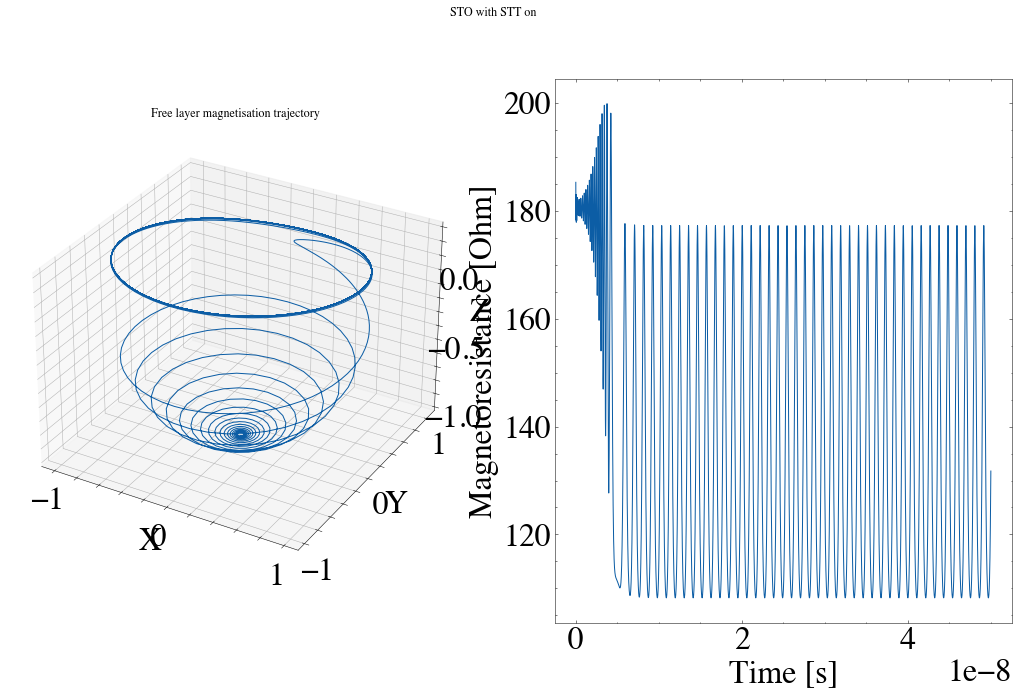

In [7]:
df = pd.read_csv('STT.csv', sep=';')
plot_trajectories(df, title="STO with STT on")



We will also run the same simulation but with the STT turned off, to see if the spin polarised current flow actually helps to sustain the oscillations.

In [8]:
l1 = Layer(id="free", 
           mag=CVector(0., 0., -1.), 
           anis=CVector(0, 0., 1.), 
           Ms=1200e3,
           thickness=1.4e-9, 
           cellSurface=7e-10 * 7e-10, 
           demagTensor=demagTensor, 
           dipoleTensor=dipoleTensor,
           includeSTT=False)
l2 = Layer(id="bottom", 
           mag=CVector(0., 1., 1.), 
           anis=CVector(0, 1., 1.), 
           Ms=1000e3, 
           thickness=3e-9, 
           cellSurface=7e-10 * 7e-10, 
           demagTensor=demagTensor, 
           dipoleTensor=dipoleTensor)

junction = Junction([l1, l2], "noSTT.csv", 100, 200)
junction.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(800e3))
junction.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1500e3))

junction.runSimulation(50e-9, 1e-13, True, False)

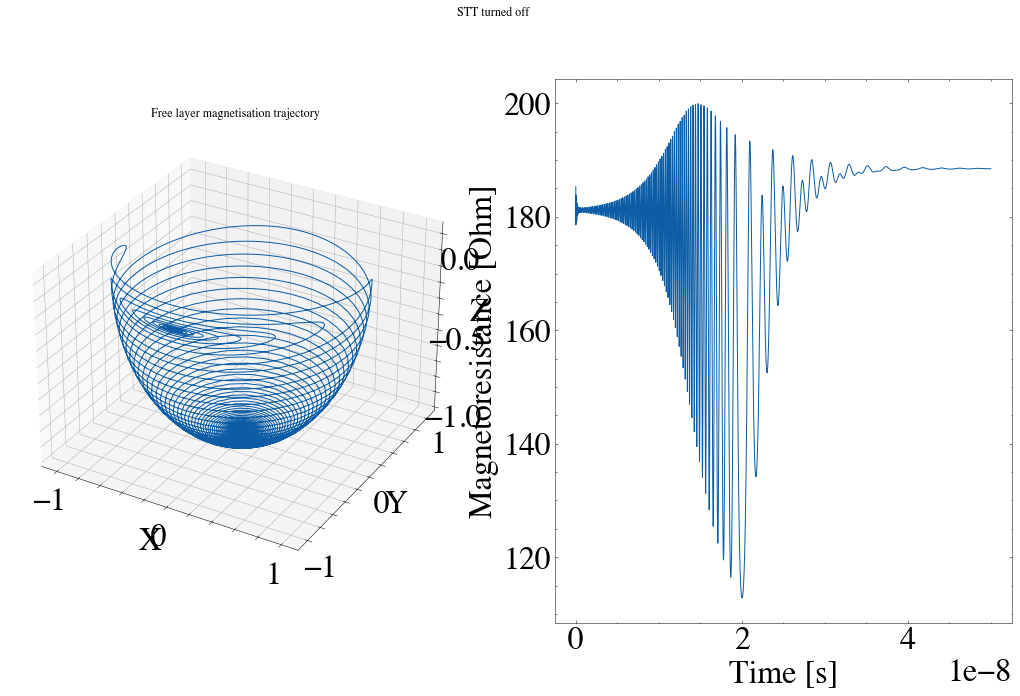

In [9]:
df = pd.read_csv('noSTT.csv', sep=';')
plot_trajectories(df, title="STT turned off")

It's pretty clear that when we turned off the current flow, the oscillations are progressively damped until the magnetisation rests on some equilibrium position.